# Random Forest Regression Process and Analysis for Wind Data

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Data Preprocessing

First, we read in the dataset.

In [2]:
df = pd.read_csv("../data/wind.csv")
df.head(5)

Now, we must shuffle the datasets to reduce bias.

In [3]:
df = df.sample(frac=1)
df.head(5)

Looking at each dataset, we can identify which variables we want to use
for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for
training and 20% for testing.

In [5]:
X_train = X[:100000]
X_test = X[100000:]
y_train = y[:100000]
y_test = y[100000:]

Models typically perform better when input values are within a certain
range, like \[-1, 1\] for example. We scale the data points
appropriately.

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 0.29976876, -1.55213354,  0.51397118],
       [-0.19081527, -1.80102981,  0.51397118],
       [ 0.45349097, -0.55854175,  0.51397118],
       ...,
       [-0.98926974, -0.04632361,  0.51397118],
       [ 1.01246158,  2.31043674, -0.67408559],
       [-0.93654137,  1.82255592,  0.51397118]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be
trained and fit.

In [7]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor() In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   RandomForestRegressor ? Documentation for RandomForestRegressor i Fitted RandomForestRegressor()

With a trained model, predictions can now be made.

In [8]:
display = y_test.reset_index()
preds = reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {preds[i][0]:.2f}\tactual energy: {display.at[i, 'generated_energy']:.2f}\tpredicted cost: {preds[i][1]:.2f}\tactual cost: {display.at[i, 'cost']:.2f}")

Predictions
----------------------
predicted energy: 83754.58  actual energy: 83847.86 predicted cost: 53602934.30 actual cost: 53662631.64
predicted energy: 71218.08  actual energy: 72733.57 predicted cost: 45579569.00 actual cost: 46549485.59
predicted energy: 12278.47  actual energy: 12532.50 predicted cost: 7367082.12  actual cost: 7519499.96

## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize
the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error
(RMSE), and Mean Absolute Percentage Error (MAPE).

In [9]:
r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric  Score
-----------------------
r2  [0.91837919 0.886822  ]
rmse    [   9016.1235774  6597654.69852586]
mape    [0.12685824 0.12691037]

#### Feature Importances

Feature importances give insights into the features that each decision
tree in the random forest use to split most often. Results are portrayed
in percentages.

In [10]:
features = ['lat','long','capacity',]

importances = reg.feature_importances_
indices = np.argsort(importances)

print("Importances")
print('----------------------')
for i in indices:
    print(f"{features[i]}: {importances[i]*100}")

Importances
----------------------
capacity: 20.135246241505772
lat: 35.00933261524246
long: 44.855421143251775

#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which
are then used to test a model. The model is then scored using the same
metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is
rigorous, and the *entire* dataset is used.

In [14]:
kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: 0.9109908237527048
RMSE Average: 3181739.2057383326
MAPE Average: 0.13390596472645255

### Graphs

Graphs of the Random Forest model fits on each of the input features,
for each target.

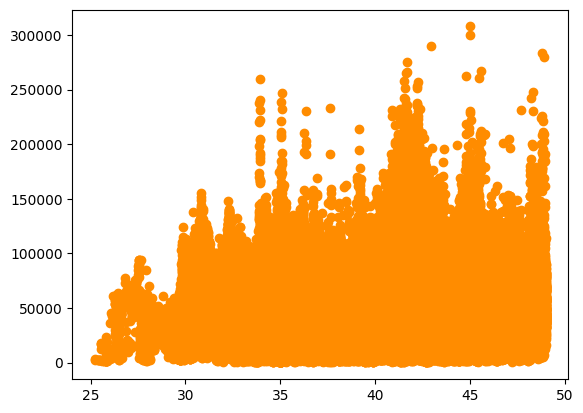

In [23]:
plot_x = pd.DataFrame()

plt.scatter(X.loc[:,["lat"]], y.loc[:,['generated_energy']], color='darkorange', label='data')
plt.plot(X_test, preds, color='c', label="model")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

A graph of the feature importances. This helps to visualize the
magnitude of importance of each feature, and compare their impact
against one another.

In [14]:
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

A graph of one of the decision trees in the random forest. This displays
the decision making process the model takes to arive at predictions.

In [15]:
fn = ['lat','long','capacity']
cn = ['generated_energy','cost']
plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],feature_names=fn,class_names=cn,filled=True, max_depth=3)
plt.show()